In [1]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
import matplotlib.pyplot as plt
import math
import os
import uproot
import json
import gc

In [2]:
warnings.filterwarnings('ignore', 'No format checks')

In [3]:
path = '/project01/ndcms/cmoore24/skims/full_skims/nolepton/mc'

In [4]:
columns = ['goodjets']

In [5]:
qcd = {}
files = os.listdir(f'{path}')
for i in files:
    if ('qcd' in i) and ('300' not in i):
        print(i)
        qcd[i.rstrip('.parquet')] = ak.from_parquet(f'{path}/{i}', columns=columns)

qcd_1000to1400
qcd_1400to1800
qcd_1800to2400
qcd_2400to3200
qcd_3200toInf
qcd_470to600
qcd_600to800
qcd_800to1000


In [6]:
def nan_remover(sample):
    if type(sample) == dict:
        for j in sample:
            mask = ak.ones_like(sample[j][sample[j].fields[0]], dtype='bool')
            mask = ak.fill_none(mask, True)
            for k in sample[j].fields:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
            sample[j] = sample[j][mask]
    else:
        mask = ak.ones_like(sample[sample.fields[0]], dtype='bool')
        mask = ak.fill_none(mask, True)
        for j in sample.fields:
            if sample[j].fields == []:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j])))
            else:
                for k in sample[j].fields:
                    mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
        sample = sample[mask]
    return mask

In [7]:
for i in qcd:
    # for j in qcd[i].fields:
    #     if j == 'event':
    #         continue
    #     else:
    #         qcd[i][j] = ak.firsts(qcd[i][j])
    qcd[i] = qcd[i][qcd[i].goodjets.msoftdrop <= 170]
    qcd[i] = qcd[i][qcd[i].goodjets.msoftdrop >= 80]
    qcd[i] = qcd[i][qcd[i].goodjets.pt >= 475]
    qcd[i] = qcd[i][qcd[i].goodjets.pt <= 950]
    qcd[i] = qcd[i][qcd[i].goodjets.btag_count == 0]
    qcd[i] = qcd[i][qcd[i].goodjets.trigger_mask]

In [8]:
# for i in qcd:
#     mask = (nan_remover(qcd[i]))
#     qcd[i] = qcd[i][mask]

In [9]:
IL = 44.99
xsec = {}
xsec['qcd_300to470'] = 6833 #1300
xsec['qcd_470to600'] = 549.5
xsec['qcd_600to800'] = 156.5
xsec['qcd_800to1000'] = 26.22
xsec['qcd_1000to1400'] = 7.475
xsec['qcd_1400to1800'] = 0.6482
xsec['qcd_1800to2400'] = 0.08742
xsec['qcd_2400to3200'] = 0.005237
xsec['qcd_3200toInf'] = 0.0001353

In [10]:
qcd_frac = {}
for i in qcd:
    qcd_frac[i] = ((xsec[i]*1000)*IL)/len(qcd[i])
qcd_frac['tot'] = sum(qcd_frac.values())
sval = {}
for i in qcd:
    sval[i] = qcd_frac[i]/qcd_frac['tot']
combed = {}
for i in list(qcd.keys()):
    temp = qcd[i]
    combed[i] = temp[np.random.rand(len(temp)) < sval[i]]
    # del(qcd[i])
    # gc.collect()
qcd_stitched = ak.concatenate([combed[x] for x in combed])

In [12]:
qcd_msd = qcd_stitched.goodjets.pt
qcd_stitched_hist = hist.Hist.new.Reg(40, 475, 950, name='msd', label='QCD MSD').Weight()
qcd_stitched_hist.fill(msd=qcd_msd);

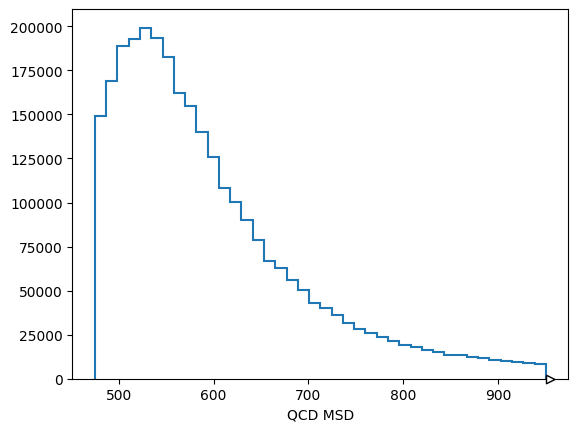

In [13]:
qcd_stitched_hist.plot1d()
#plt.yscale('log')
plt.show()

In [14]:
qcd_hist_dict = {}
for i in qcd:
    temp_qcd_hist = hist.Hist.new.Reg(40, 475, 950, name='msd', label='QCD MSD').Weight()
    temp_qcd_hist.fill(msd=qcd[i].goodjets.pt);
    qcd_hist_dict[i] = temp_qcd_hist

In [15]:
path = '/scratch365/cmoore24/training/hgg/batch/ml_results_checking'
with open(f'{path}/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)
del(totals['ww4q'])

In [16]:
with open(f'{path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [17]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2

In [18]:
totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

In [19]:
for i in qcd_hist_dict:
    scale = ((44.99*(xsecs[i]*1000))/totals[i])
    qcd_hist_dict[i].view(flow=True)[:] *= scale

In [20]:
qcd_hist = sum(value for key, value in qcd_hist_dict.items())

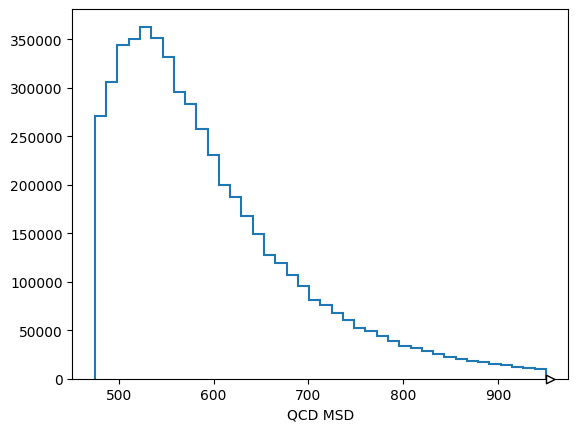

In [21]:
qcd_hist.plot1d()
#plt.yscale('log')
plt.show()

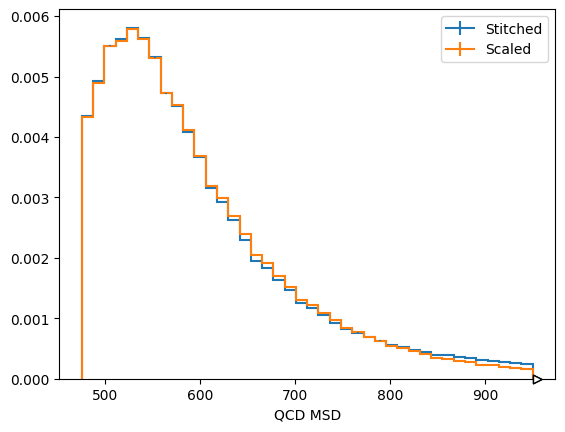

In [26]:
qcd_stitched_hist.plot1d(density=True, label='Stitched')
qcd_hist.plot1d(density=True, label='Scaled')
#plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
#ak.to_parquet(qcd_stitched, '/project01/ndcms/cmoore24/skims/reduced_skims/stitched_qcd/qcd_ecfs.parquet')

In [27]:
len(qcd_stitched)

2889434